# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la

import pandas as pd
import seaborn as sns

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [2]:
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

In [3]:
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [4]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k], ddof=0)
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set


In [4]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

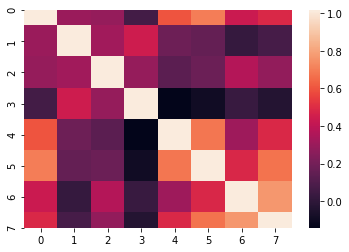

In [5]:
# Preliminary questions
Mcov=np.cov(M_train.T)
sns.heatmap(Mcov)

La majorité des attributs sont décorrélés entre eux. 
Cependant certains ont une corrélation proche de 1.La diagonale est bien 1 partout.
->  Par exemple l'attribut 6 est quasiment corrélé avec le 7 : il est possible que lors de l'implémentation de l'estimateur, l'utilisation d'une seule des deux soit nécessaires.
Nous allons regarder en détail leur covariance avec les targets pour confirmer le besoin de garder deux attributs ou pas.


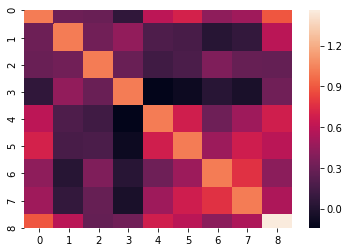

In [9]:
#Ajouter les targets dans X pour estimation de la covariance avec attributs et cible
t_train=np.array([data_train[:,8]])
M_train_t = np.concatenate((M_train,t_train.T),axis=1)
M_cov_t=np.cov(M_train_t.T)
sns.heatmap(M_cov_t)

La norme ici n'est plus échelonnée sur 1 car les target ne sont pas normalisées. On remarque que la target est corrélée avec les features. On pourra donc réaliser un modèle de prédiction.

Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [13]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [40]:
# Exercise 1
#On va d'abord créer la matrice X_train (X_train en rajoutant la colonne des 1) :
t_train = data_train[:,8]   # target column
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1)

print (f"Le rang de la X_train est : {np.linalg.matrix_rank(X_train)}")
print(f"Nombre d'attribut : {np.shape(X_train)[1]}")

Le rang de la X_train est : 9
Nombre d'attribut : 9


# Rang de $X_{train}$ :
X_train est de rang plein donc on pourra calculer son pseudo inverse de Moore Penrose dans la suite.
Par la formule de cours on connait la valeur de l'estimateur optimal :

$MP = (X^{T}X)^{-1}X$

In [15]:
# Calcul de cette matrice :
MP = np.dot(np.linalg.inv(np.dot(X_train.T,X_train)),X_train.T) #Pseudo inverse de Moore Penrose

# Estimateur : $\beta_{hat}$

In [42]:
beta_hat=MP@t_train
print(f" Le premier coefficient b0 est le biais du modèle et il vaut : {np.round(beta_hat[0],3)}")
print(f"L'estimation de t0 vaut {np.round(np.mean(t_train),3)}")

print(f"Estimateur :{np.round(beta_hat,3)}")


 Le premier coefficient b0 est le biais du modèle et il vaut : 2.452
L'estimation de t0 vaut 2.452
Estimateur :[ 2.452  0.711  0.29  -0.141  0.21   0.307 -0.287 -0.021  0.275]


Dans le cas de la régression des moindres carrés, on a bien $t_0 = b_0$ (le biais du modèle)

In [20]:
#La prédiction de l'erreur:
t_test_hat = X_test@beta_hat


Error_LS = np.linalg.norm(t_test_hat-t_test,2)**2/N_test
print(f"L'erreur quadratique du modèle est de {np.round(Error_LS,3)}")

L'erreur quadratique du modèle est de 0.521


L'erreur quadratique du modèle s'écrit $E_{LS} = \frac{1}{N_{test}}\|\hat{\beta}^{T}X_{test}-t_{test}\|^{2}$.\
On divise l'erreur par $N_{test}$ pour pouvoir comparer les modèles entres eux, indépendament de la taille de l'ensemble de test. \ 
Dans la suite, cette erreur sera comparée aux autres.

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

# Exercise 2

   1. Définissons les fonctions pour calculer la variance $v_{j}$, $\hat{\sigma} $ et enfin $Z_{score}$

Cette fonction permet de renvoyer une liste des éléments diagonaux de  $(X^TX)^{-1}$ qui correpondent aux $(v_j)$

In [29]:
# Renvoie une liste avec les éléments diagonaux
def var(X):
    return(np.diag(inv(X.T.dot(X))))

In [28]:
def sigma_hat(beta_hat,X,t):
    p=len(beta_hat)-1 #On enlève 1 pour enlever le biais
    N=len(X)
    t_hat=X@beta_hat
    return(np.sqrt(np.linalg.norm((t-t_hat),2)**2/(N-p-1))) #On applique la formule qui estime la variance

In [30]:
def z_score(X,beta_hat,t):
    Z=[]
    Var = var(X)
    s_hat=sigma_hat(beta_hat,X,t)
    for j in range(0,len(beta_hat)):
        Z.append(beta_hat[j]/(s_hat*np.sqrt(Var[j]))) 
    return(Z)

In [33]:
zScore=z_score(X_train,beta_hat,t_train)
print(f"Vecteur des Z_score:{np.round(zScore,2)}")

Vecteur des Z_score:[28.18  5.37  2.75 -1.4   2.06  2.47 -1.87 -0.15  1.74]


In [34]:
Id_selected = []
Id_rejected = []
for i in range (len(zScore)):
    if zScore[i]>2:             #On inclut l'attribut en question si son Z_score > 2 
        Id_selected.append(i) 
    else:
        Id_rejected.append(i)  #On rejète l'hypothèse H0
        
        
print(f"Indices sélectionnés :  {Id_selected}")
print(f"Indices rejetées :  {Id_rejected}")



Indices sélectionnés :  [0, 1, 2, 4, 5]
Indices rejetées :  [3, 6, 7, 8]


# A. Estimateur en annulant les attributs 

In [43]:
beta_hat_new = np.copy(beta_hat)
beta_hat_new[Id_rejected] = 0 

print(f"Taille de beta_hat_new : {len(beta_hat_new)}")
print(f"Estimateur : {np.round(beta_hat_new,2)}")

Taille de beta_hat_new : 9
Estimateur : [2.45 0.71 0.29 0.   0.21 0.31 0.   0.   0.  ]


In [36]:
t_test_hat = X_test@beta_hat_new
Error_LS = np.linalg.norm(t_test_hat-t_test,2)**2/N_test
print(f"L'erreur quadratique du modèle est de {np.round(Error_LS,3)}")

L'erreur quadratique du modèle est de 0.452


On constate une diminution de l'erreur quadratique. On peut en conclure que certains attributs n'étaient pas nécessaires à la prédiction du modèle. Les utiliser ne permet pas une meilleure régression linéaire. 
Maintenant nous allons vérifier si construire un estimateur sans ces attributs nous permet d'avoir un estimateur encore plus performant.

# B.  Réduisons maintenant l'espace des features à l'aide de la sélection du $Z_{score}$

In [39]:
t_train_selected = data_train[:,8]  # target column
N_train_selected = t_train_selected.shape[0]
X_train_selected = np.concatenate((np.ones((N_train_selected,1)), M_train[:,Id_selected]), axis=1) 
#On sélectionne uniquement les features avec un Z_score > 2

print (f"Le rang de la X_train_selected est : {np.linalg.matrix_rank(X_train_selected)}")
print(f"Nombre d'attributs : {np.shape(X_train_selected)[1]}")

Le rang de la X_train_selected est : 6
Nombre d'attribut : 6


In [44]:
MP_selected = np.dot(np.linalg.inv(np.dot(X_train_selected.T,X_train_selected)),X_train_selected.T) #Pseudo inverse de Moore Penrose
 
beta_hat_selected=MP_selected@t_train_selected
print(f" Le premier coefficient b0 est le biais du model et il vaut : {np.round(beta_hat_selected[0],3)}")
print(f"Estimateur :{np.round(beta_hat_selected,3)}")

 Le premier coefficient b0 est le biais du model et il vaut : 2.452
Estimateur :[ 2.452  0.727  0.355 -0.058  0.281 -0.151]


In [45]:
t_test_selected = data_test[:,8]   # target column
N_test_selected = data_test.shape[0]
X_test_selected = np.concatenate((np.ones((N_test_selected,1)), M_test[:,Id_selected]), axis=1)
#On sélectionne uniquement les features avec un Z_score > 2

t_test_hat = X_test_selected@beta_hat_selected
Error_LS = np.linalg.norm(t_test_hat-t_test,2)**2/N_test
print(f"L'erreur quadratique du modèle est de {np.round(Error_LS,3)}")

L'erreur quadratique du modèle est de 0.423


En diminuant la dimension de l'espace des features en considérons seulement les features rejetant $H_0$, on diminue l'erreur quadratique. Ce modèle est plus performant que les deux autres.
Deux choses à noter : on améliore le modèle en terme d'erreur et le modèle a moins de paramètres.

Résumé des erreurs quadratiques : 

 La régression linéaire simple nous donne une erreur de : 0.521  \
 La régression avec la mise à 0 des composantes de $\beta$ : 0.452 \
 La régression avec régression avec uniquement les attributs sélectionnés : 0.423
 
 
 Maintenant la question est la suivante : la comparaison des modèles est-elle encore valable pour d'autres jeu de données?
 En effet nous voudrions savoir si cette conclusion de performance est indépendante du jeu de données en question.
 Il est possible de chercher à vérifier cette conclusion avec la génération de jeu de données générés selon la même distribution que celui de départ (encore faut-il connaitre la distribution de celui de départ).
 
$ \textit{ref : Introduction to machine learning :  Tue Herlau, Mikkel N.Schmidt and Morten Morup - Lectures notes Srping 2020}$
 

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

On estime d'abord $t_0$ à part. Il ne doit pas faire partie de la régularisation.

In [74]:
t_train = data_train[:,8]
t_test = data_test[:,8] # column of targets

t0 = np.mean(t_train)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8])) 

La matrice de Moore Penrose $MP = (\lambda I +X^{T}X)^{-1}X$

In [75]:
N_train = t_train.shape[0]
X_train =  M_train[:,0:8] #On ne considère pas le bais dans la régularisation

lambd=25

# Calcul de cette matrice :
MP_reg = np.dot(np.linalg.inv(lambd*np.identity(8)+np.dot(X_train.T,X_train)),X_train.T) #Pseudo inverse de Moore Penrose

beta_hat_reg=np.hstack((np.array([t0]).T,MP_reg@t_train)) #On rajoute le biais estimé à part.

print(f"Le premier coefficient b0 est le biais du modèle et il vaut : {np.round(beta_hat_reg[0],3)}")
print(f"Estimateur :{np.round(beta_hat_reg,3)} \n")
print(f"Tableau des indices de l'estimateur trié : {np.argsort(np.abs(beta_hat_reg))}")
print(f"Indices acceptés par le test Z-score: {Id_selected}")
print(f"Indices rejetés par le test Z-score : {Id_rejected}")

Le premier coefficient b0 est le biais du modèle et il vaut : 2.452
Estimateur :[ 2.452  0.422  0.249 -0.042  0.166  0.231  0.011  0.043  0.132] 

Tableau des indices de l'estimateur trié : [6 3 7 8 4 5 2 1 0]
Indices acceptés par le test Z-score: [0, 1, 2, 4, 5]
Indices rejetés par le test Z-score : [3, 6, 7, 8]


On remarque qu'on fait tendre les coefficients "les moins intéréssants" pour la régression tendent vers 0. C'est le but du terme de régularisation de la fonction de coût.

Le tableau trié des indices de l'estimateur (du plus petit au plus grand) nous montre les attributs les plus importants.
On remarque que les termes de l'estimateur les plus importants sont ceux dont les indices ont été sélectionnés par le z-score et inversement pour ceux non sélectionnés. 

In [76]:
t_hat_reg = X_test.dot(beta_hat_reg)
Error_LS = np.linalg.norm(t_hat_reg-t_test,2)**2/N_test
Error_RR = Error_LS + lambd*np.linalg.norm(beta_hat_reg,2)/N_test

print(f"L'erreur quadratique du modèle est de {np.round(Error_LS,8)}")

L'erreur quadratique du modèle est de 0.49394216


 # C. Estimation de l'erreur pour le modèle linéaire $\beta_{best}$

In [77]:
beta_best = np.array([2.477 ,0.74 ,0.316,0, 0, 0, 0, 0, 0])
t_hat_best = X_test.dot(beta_best)

Error_LS = np.linalg.norm(t_hat_best-t_test,2)**2/N_test
print(f"L'erreur quadratique du modèle est de {np.round(Error_LS,8)}")

L'erreur quadratique du modèle est de 0.4936867


# Conclusion Partie 2


Résumé des erreurs quadratiques : 

 La régression linéaire simple nous donne une erreur de : 0.521  \
 La régression avec la mise à 0 des composantes de $\beta$ : 0.452 \
 La régression avec régression avec uniquement les attributs sélectionnés : 0.423 
            
 La régression régularisé avec $\lambda=25$  : 0.4939 \
 La régression $\beta_{best}$ : 0.4936
            

On remarque que le modèle régularisé a de meilleures performances que le modèle de régression simple. \
Néanmoins, il est moins bon que les modèles calculés avec les $Z_ {score}$
Le modèle régularisé et $\beta_{best}$ on quasiment les mêmes résultats. \
(Pourquoi $\beta_{best}$ n'a pas le même biais ?)

L'influence du paramèrtre de régularisation lambda est significative.\
En effet un grand lambda ne permet pas une grande
variance dans notre modèle et augmente le biais. Inversement pour lambda petit.\
Dans la suite, on trouvera un compromis sur la valeur de lambda.


# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


In [85]:
import pdb
def compute_MP(X,lambd):
    return(np.dot(np.linalg.inv(lambd*np.identity(8)+np.dot(X.T,X)),X.T))

def split_data_KFold_Cross_Val(data,K=10):
    data_train_test_split =[]
    data_size = len(data)
    p_test_size = 1/K
    Index_permut = np.random.permutation(data_size)
    test_size = int(data_size*p_test_size)
    
    for j in range(0,K-1): 
        
        data_test=data[Index_permut[j*test_size:(j+1)*test_size]]   # original data
        data_train=data[np.delete(Index_permut,range(j*test_size,(j+1)*test_size))]
        
        data_train_test_split.append([data_train,data_test])
    
    data_train=data[np.delete(Index_permut,range((K-1)*test_size,data_size))]
    data_test=data[Index_permut[(K-1)*test_size:data_size]]   # original data
    
    data_train_test_split.append([data_train,data_test])
    
    return(data_train_test_split)

def data_to_rawdata_target_normalized(data_sample,K):
    rawdata_target_normalized = []
    data_train_test_split = split_data_KFold_Cross_Val(data,K)
    for j in range(K):
        data_sample=data_train_test_split[j]
        data_train,data_test = data_sample[0],data_sample[1]

        M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
        moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
        sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )
        M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

        t_test = data_test[:,8]   # target column
        N_test = data_test.shape[0]
        X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) #X_test_tild

        t_train = data_train[:,8]   # target column
        N_train = data_train.shape[0]
        X_train =  M_train[:,0:8]
        
        rawdata_target_normalized.append((X_train,X_test,t_train,t_test))
    return(rawdata_target_normalized)

In [139]:
def Lambda_CV(data,K=10,lambda_list=range(0,40)):

    Error_Liste=[]
    rawdata_target_normalized = data_to_rawdata_target_normalized(data,K)

    for j in range(K):
        X_train,X_test,t_train,t_test=rawdata_target_normalized[j]
        t0 = np.mean(t_train)
        Error_Liste_lambda =[]
        for lambd in lambda_list:

                MP_reg= compute_MP(X_train,lambd)
                N_test = len(t_test)
                beta_hat_reg=np.hstack((np.array([t0]),MP_reg@t_train))
                t_hat_reg = X_test.dot(beta_hat_reg)
                
                Error_Liste_lambda.append(np.round(np.linalg.norm(t_hat_reg-t_test,2)**2,3)/N_test)

        Error_Liste.append(Error_Liste_lambda)

    return(np.mean(Error_Liste,axis=0))

Le meilleur modèle régularisé a une erreur quadratique qui vaut 0.538 pour lambda = 6.0


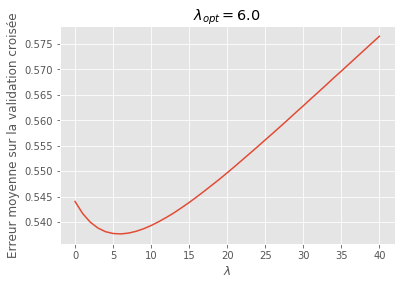

In [146]:
K=10
lambda_list=np.linspace(0,40,41)

Error_Liste = Lambda_CV(data_train,K,lambda_list)

print(f"Le meilleur modèle régularisé a une erreur quadratique qui vaut {np.round(np.min(Error_Liste),3)} pour lambda = {lambda_list[np.argmin(Error_Liste)]}")

plt.style.use('ggplot')
plt.title("$\lambda_{opt}=$"+f"{lambda_list[np.argmin(Error_Liste)]}")
plt.xlabel("$\lambda$");plt.ylabel("Erreur moyenne sur la validation croisée")
plt.plot(lambda_list,Error_Liste)

On remarque qu'en relancant cette simulation la valeur de lambda optimal change.
C'est normal car notre jeu de données est petit et que la valeur moyenne fluctue selon la répartition des données après mélange (séparation en 10 qui est aléatoire). On se doute bien qu'en relevant la valeur optimale de lambda pour un grand nombre de permutations, l'espérance du lambda opt obtenu sera la meilleure valeure que l'on peut choisir.

Nous allons pour cela procéder à une estimation via une méthode de Monte-carlo afin de déterminer la valeur de lambda opt qui est la plus fréquente. Nous nous attendons à observer une gaussienne. Nous allons travailler sur des intervalles pour lambda plus réduit pour mieux cerner lambda.
cf plus bas : 

Nous allons tester cette recherche sur l'intervalle [0,40] avec 41 valeurs de lambda testées à chaque fois.


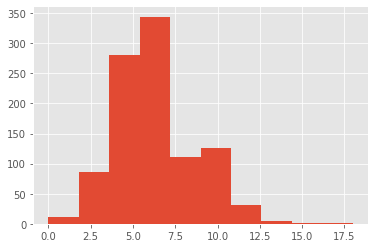

In [138]:
#Monte Carlo
K=10
lambda_list=np.linspace(0,40,41)
Nb_iter = 1000
Lambda_opt_list=[]
for j in range(Nb_iter):
    Lambda_opt_list.append(lambda_list[np.argmin(Lambda_CV(data_train,K,lambda_list))])

plt.hist(Lambda_opt_list)
plt.show()
                           


Cette fois avec 10000 itérations : 

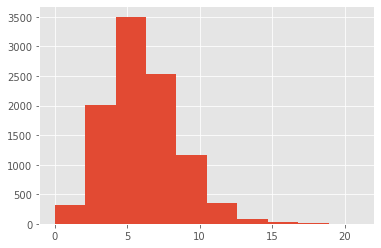

In [131]:
#Monte Carlo
from IPython.display import clear_output
K=10
lambda_list=np.linspace(0,40,41)
Nb_iter = 10000
Lambda_opt_list=[]
counter = 0
for j in range(Nb_iter):
    Lambda_opt_list.append(lambda_list[np.argmin(Lambda_CV(data_train,K,lambda_list))])
    counter+=1

    print(f"{round(counter/Nb_iter*100)} %")
    clear_output(wait = True)
    

plt.hist(Lambda_opt_list)
plt.show()


(0, 40)

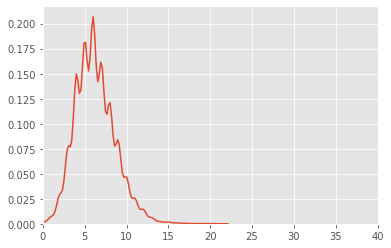

In [132]:
sns.kdeplot(Lambda_opt_list)
plt.xlim(0,40)

In [136]:
Lambda_opt_MC = np.bincount(Lambda_opt_list).argmax()
print(f"Le lambda optimal estimé à l'aide de la méthode de Monte Carlo pour 10000 itérations est :{Lambda_opt_MC}")

Le lambda optimal estimé à l'aide de la méthode de Monte Carlo pour 10000 itérations est :6


Ainsi, à l'aide de cette méthode, on obtient $\lambda_{opt} = 6$

## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

On réalise la même procédure que dans l'exercice 3 avec K = 6.

Le meilleur modèle régularisé a une erreur quadratique qui vaut 0.531 pour lambda = 8.0


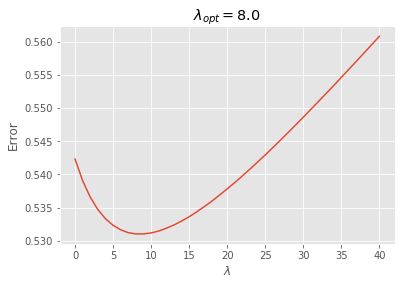

In [152]:
K=6
lambda_list=np.linspace(0,40,41)
Error_Liste = Lambda_CV(data_train,K,lambda_list)
lambd_opt, min_Error =lambda_list[np.argmin(Error_Liste)],np.round(np.min(Error_Liste),3)

print(f"Le meilleur modèle régularisé a une erreur quadratique qui vaut {min_Error} pour lambda = {lambd_opt}")

plt.style.use('ggplot')
plt.title("$\lambda_{opt}=$"+f"{lambda_list[np.argmin(Error_Liste)]}")
plt.xlabel("$\lambda$");plt.ylabel("Error")
plt.plot(lambda_list,Error_Liste)

On estime $\lambda_{opt}$ grâce à la méthode de Monte Carlo.

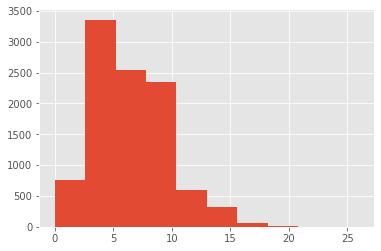

In [153]:
#Monte Carlo
from IPython.display import clear_output
K=6
lambda_list=np.linspace(0,40,41)
Nb_iter = 10000
Lambda_opt_list=[]
counter = 0
for j in range(Nb_iter):
    Lambda_opt_list.append(lambda_list[np.argmin(Lambda_CV(data_train,K,lambda_list))])
    counter+=1

    print(f"{round(counter/Nb_iter*100)} %")
    clear_output(wait = True)
    

plt.hist(Lambda_opt_list)
plt.show()

(0, 40)

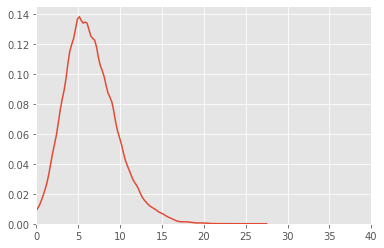

In [154]:
sns.kdeplot(Lambda_opt_list)
plt.xlim(0,40)

In [155]:
Lambda_opt_MC = np.bincount(Lambda_opt_list).argmax()
print(f"Le lambda optimal estimé à l'aide de la méthode de Monte Carlo pour 10000 itérations est :{Lambda_opt_MC}")

Le lambda optimal estimé à l'aide de la méthode de Monte Carlo pour 10000 itérations est :5


# Estimation de l'erreur sur le modèle régularisée avec $\lambda = \lambda_{opt}$

In [168]:
lambd = Lambda_opt_MC
lambd = 25
MP_reg= compute_MP(X_train,lambd)
t0 = np.mean(t_train)
beta_hat_reg=np.hstack((np.array([t0]),MP_reg@t_train))

print(f" Le premier coefficient b0 est le biais du model et il vaut : {np.round(beta_hat_reg[0],3)}")
print(f"Estimateur :{np.round(beta_hat_reg,3)}")

 Le premier coefficient b0 est le biais du model et il vaut : 2.452
Estimateur :[ 2.452  0.422  0.249 -0.042  0.166  0.231  0.011  0.043  0.132]


In [169]:
t_hat_reg = X_test.dot(beta_hat_reg)

Error_LS = np.linalg.norm(t_hat_reg-t_test,2)**2/N_test
print(f"L'erreur quadratique du modèle est de {np.round(Error_LS,8)}")

L'erreur quadratique du modèle est de 0.49394216


Le modèle régularisé avec $\lambda_{opt}$ est aussi bon que celui avec $\lambda=25$ pour cet ensemble de validation.

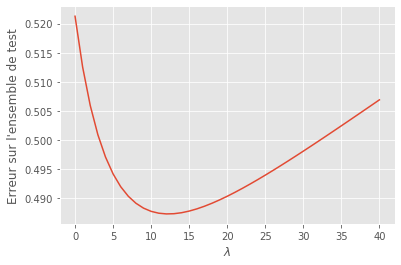

In [166]:
Error = []
for l in range(0,41):
    MP_reg= compute_MP(X_train,l)
    t0 = np.mean(t_train)
    beta_hat_reg=np.hstack((np.array([t0]),MP_reg@t_train))
    t_hat_reg = X_test.dot(beta_hat_reg)

    Error_LS = np.linalg.norm(t_hat_reg-t_test,2)**2/N_test
    Error.append(Error_LS)

plt.plot(Error)
plt.xlabel("$\lambda$");plt.ylabel("Erreur sur l'ensemble de test")
plt.show()

    

En termes de généralisation de modèle, notre étude pour calculer lambda optimal est intéressante :  l'arrivée de nouvelles données ne pertuberait pas la précision du modèle lors de l'entrainement. 

En revanche lors de la validation, on constate que lambda est bien différent. Malgré notre validation-croisée, cela n'améliore pas la précision du modèle avec l'ensemble de test.
Cela pose le problème suivant : 
Peut-on généraliser lambda avec un jeu de données suffisamment grand pour que lors
de l'estimation avec de nouvelles données la précision soit acceptable?